# Financial Numeric Entity Recognition

## Data Description

In this project, FiNER-139 is used as a dataset. FiNER-139 is comprised of 1.1M sentences annotated with eXtensive Business Reporting Language (XBRL) tags extracted from annual and quarterly reports of publicly-traded companies in the US. Unlike other entity extraction tasks, like named entity recognition (NER) or contract element extraction, which typically require identifying entities of a small set of common types (e.g., persons, organizations), FiNER-139 uses a much larger label set of 139 entity types. Another important difference from typical entity extraction is that FiNER focuses on numeric tokens, with the correct tag depending mostly on context, not the token itself.

FiNER-139 is compiled from approximately 10k annual and quarterly English reports.

The dataset was taken from: https://huggingface.co/datasets/nlpaueb/finer-139

## Importing necessary libraries & loading data

In [ ]:
%%capture
! pip install datasets
! pip install transformers --upgrade
! pip install seqeval

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import Dataset, load_dataset, load_from_disk, load_metric
from transformers import (AutoTokenizer,
                          AutoModelForTokenClassification,
                          DataCollatorForTokenClassification,
                          TrainingArguments,
                          Trainer,
                          pipeline)
from spacy import displacy
import re
from tqdm.autonotebook import tqdm
from google.colab import drive

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
dataset = load_dataset('nlpaueb/finer-139')

Generating train split:   0%|          | 0/900384 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/112494 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/108378 [00:00<?, ? examples/s]

Dataset finer-139 downloaded and prepared to /root/.cache/huggingface/datasets/nlpaueb___finer-139/finer-139/1.0.0/5f5a8eb2a38e8b142bb8ca63f3f9600634cc6c8963e4c982926cf2b48e4e55ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset.save_to_disk('finer.hf')

In [ ]:
! mv '/content/finer.hf' '/content/drive/My Drive/Data/'

In [ ]:
dataset = load_from_disk('/content/drive/MyDrive/Data/finer.hf')

In [ ]:
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

In [ ]:
train_df.head()

,id,tokens,ner_tags
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[See, accompanying, notes, to, condensed, cons...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[The, condensed, consolidated, financial, stat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[These, condensed, consolidated, financial, st...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[The, condensed, consolidated, statements, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900384 entries, 0 to 900383
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        900384 non-null  int32 
 1   tokens    900384 non-null  object
 2   ner_tags  900384 non-null  object
dtypes: int32(1), object(2)
memory usage: 17.2+ MB


FiNER-136 dataset is very large. Moreover, FinBERT (neural network architecture that I am going to use for numeric entity recognition) training is quite computationaly expensive. Training on the whole FiNER-136 dataset will take ~44 hours, so I will reduce training and validation data to make training possible in colab.

In [ ]:
def select_sentences(df, n):
  counter = 0
  ids = []
  for i in range(len(df)):
    if len(np.unique(df['ner_tags'].iloc[i])) > 1 and counter <= n:
      ids.append(i)
      counter += 1
  return df.iloc[ids]

In [ ]:
train_df = select_sentences(train_df, 10000)
val_df = select_sentences(val_df, 1000)
test_df = select_sentences(test_df, 100)

In [ ]:
train_df['tokens'] = train_df['tokens'].apply(lambda x: x.tolist())

In [ ]:
finer_tag_names = dataset['train'].features['ner_tags'].feature.names

First of all, let's take a look at our data and visualize some samples from the dataset

In [ ]:
# function for finding indexes of numeric indexes
def get_entity_indexes(sentence, entity):
  text = ' '.join(sentence)
  pattern = r'\b{}\b'.format(entity)
  result = re.search(pattern, text)
  return result.start(), result.end()

In [ ]:
# function for visualization of numeric entities and their categories
def visualize_entities(sentence, tag_names, tags):
  entities = []
  for i in range(len(tags)):
    if tags[i] not in [0, -100]:
      entity = sentence[i]
      start, end = get_entity_indexes(sentence, entity)
      entities.append({'start': start, 'end': end, 'label': tag_names[tags[i]][2:]})
  if entities:
    text = ' '.join(sentence)
    dic_ents = {'text': text, 'ents': entities, 'title': None}
    displacy.render(dic_ents, manual=True, style='ent', jupyter=True)

In [ ]:
x = 9
visualize_entities(train_df['tokens'].iloc[x], finer_tag_names, train_df['ner_tags'].iloc[x])
y = 99
visualize_entities(train_df['tokens'].iloc[y], finer_tag_names, train_df['ner_tags'].iloc[y])
z = 999
visualize_entities(train_df['tokens'].iloc[z], finer_tag_names, train_df['ner_tags'].iloc[z])

## Data Preprocessing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
text_token_counts = []
for _, row in tqdm(train_df.iterrows()):
  text_token_count = len(tokenizer.encode(row['tokens'], is_split_into_words=True))
  text_token_counts.append(text_token_count)

0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors


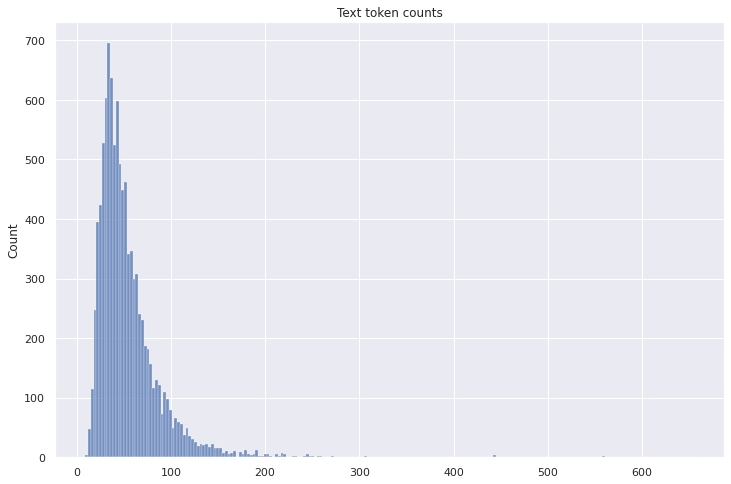

In [ ]:
# visualizing token length distribution
sns.set(rc={'figure.figsize': (12, 8)})
sns.histplot(text_token_counts).set(title='Text token counts')
plt.show()

In [ ]:
print('99,9% of tokenized sentences have length <= {}'.format(int(np.quantile(text_token_counts, 0.999))))

99,9% of tokenized sentences have length <= 370


In token classification task there is a size mismatch problem between inputs and labels: input ids returned by the tokenizer are longer than the lists of labels our dataset contain, because tokenizer adds special tokens used by the model ([CLS] at the beginning and [SEP] at the end). It is necessary to expand our label list to match the tokens. The first rule we’ll apply is that special tokens get a label of -100. This is because by default -100 is an index that is ignored in the loss function. Then, each token gets the same label as the token that started the word it’s inside, since they are part of the same entity. I will use tokenize_and_align_labels function, which provides all necessary functionality.

In [ ]:
# function for handling size mismatch problem between inputs and labels
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, max_length=370, padding=True) 
    labels = [] 
    for i, label in enumerate(examples['ner_tags']): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        previous_word_idx = None 
        label_ids = []
        # special tokens are originally mapped to None 
        # we need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # for the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token                 
                label_ids.append(label[word_idx]) 
            else: 
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                # mask the subword representations after the first subword       
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs['labels'] = labels 
    return tokenized_inputs

In [ ]:
train_df = Dataset.from_pandas(train_df)
val_df = Dataset.from_pandas(val_df)

In [ ]:
# map train data
train_df = train_df.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
train_df.save_to_disk('finer_train_tokenized_2.hf')

In [ ]:
! mv '/content/finer_train_tokenized_2.hf' '/content/drive/My Drive/Data/'

In [ ]:
train_df = load_from_disk('/content/drive/MyDrive/Data/finer_train_tokenized_2.hf')

In [ ]:
# map validation data
val_df = val_df.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
val_df.save_to_disk('finer_val_tokenized_2.hf')

In [ ]:
! mv '/content/finer_val_tokenized_2.hf' '/content/drive/My Drive/Data/'

In [ ]:
val_df = load_from_disk('/content/drive/MyDrive/Data/finer_val_tokenized_2.hf')

## Model Training

In [ ]:
# mappings from ID to label and vice versa
id2label = {i: label for i, label in enumerate(finer_tag_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
# loading model
model = AutoModelForTokenClassification.from_pretrained('ProsusAI/finbert',
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([279, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([279]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
train_args = TrainingArguments(output_dir='finer_output',
                               evaluation_strategy='epoch',
                               learning_rate=2e-4,
                               per_device_train_batch_size=16,
                               per_device_eval_batch_size=16,
                               num_train_epochs=4,
                               weight_decay=0.05)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
metric = load_metric('seqeval')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [ ]:
# function for computing metrics for model performance evaluation
def compute_metrics(eval_preds): 
  pred_logits, labels = eval_preds 
  pred_logits = np.argmax(pred_logits, axis=2) 
  # remove all the values where the label is -100
  predictions = [[finer_tag_names[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
                 for prediction, label in zip(pred_logits, labels)] 
  true_labels = [[finer_tag_names[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
                 for prediction, label in zip(pred_logits, labels)] 
  results = metric.compute(predictions=predictions, references=true_labels) 
  return {"precision": results["overall_precision"],
          "recall": results["overall_recall"],
          "f1": results["overall_f1"],
          "accuracy": results["overall_accuracy"]}

In [ ]:
trainer = Trainer(model,
                  train_args,
                  train_dataset=train_df,
                  eval_dataset=val_df,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, __index_level_0__, ner_tags, id. If tokens, __index_level_0__, ner_tags, id are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10001
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2504
  Number of trainable parameters = 109106199
You're using a BertTokenizerFast tokenizer. Please note that with a fast to

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.124900,0.196419,0.622761,0.570275,0.595364,0.963786
2,0.065600,0.190659,0.610624,0.614938,0.612773,0.965383
3,0.036600,0.193954,0.651348,0.640172,0.645711,0.967849
4,0.008500,0.197615,0.658907,0.657078,0.657991,0.968807


Saving model checkpoint to finer_output/checkpoint-500
Configuration saved in finer_output/checkpoint-500/config.json
Model weights saved in finer_output/checkpoint-500/pytorch_model.bin
tokenizer config file saved in finer_output/checkpoint-500/tokenizer_config.json
Special tokens file saved in finer_output/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, __index_level_0__, ner_tags, id. If tokens, __index_level_0__, ner_tags, id are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

TrainOutput(global_step=2504, training_loss=0.05056587069000775, metrics={'train_runtime': 2825.4843, 'train_samples_per_second': 14.158, 'train_steps_per_second': 0.886, 'total_flos': 7572782131292880.0, 'train_loss': 0.05056587069000775, 'epoch': 4.0})

In [ ]:
trainer.save_model('finbert_20epoch')

Saving model checkpoint to finbert_20epoch
Configuration saved in finbert_20epoch/config.json
Model weights saved in finbert_20epoch/pytorch_model.bin
tokenizer config file saved in finbert_20epoch/tokenizer_config.json
Special tokens file saved in finbert_20epoch/special_tokens_map.json


In [ ]:
! mv '/content/finbert_20epoch' '/content/drive/My Drive/Data/'

## Inference

In [ ]:
# building pipeline for inference
model_checkpoint = '/content/drive/MyDrive/Data/finbert_20epoch'
token_classifier = pipeline('token-classification', model=model_checkpoint, aggregation_strategy='simple')

In [ ]:
# function for prediction visualization
def visualize_preds(sentence, preds):
  entities = []
  for pred in preds:
    entity = pred['entity_group']
    start, end = pred['start'], pred['end']
    entities.append({'start': start, 'end': end, 'label': entity})
  dic_ents = {'text': sentence, 'ents': entities, 'title': None}
  displacy.render(dic_ents, manual=True, style='ent', jupyter=True)

Let's visualize some samples from test dataset and check how the model performs on unseen data

In [ ]:
# inference
for i in range(1, 6):
  sentence = ' '.join(test_df['tokens'].iloc[i])
  preds = token_classifier(sentence)
  print('Ground truth:')
  visualize_entities(test_df['tokens'].iloc[i], finer_tag_names, test_df['ner_tags'].iloc[i])
  print('Predicted:')
  visualize_preds(sentence, preds)
  print('\n')

Ground truth:


Predicted:




Ground truth:


Predicted:




Ground truth:


Predicted:




Ground truth:


Predicted:




Ground truth:


Predicted:


As can be seen from examples above, model performs quite well, even through it was trained on only 10,000 samples. The performance of the model can definitely be significantly increased by training on the whole FiNER-139 dataset, what is impossible in colab due to GPU usage limits, but you can use remote server or your own devbox instead.